### reference: 

In [1]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [2]:
from functools import partial
from multiprocessing import Pool
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image

In [3]:
start_time = time.time()

batch_size = 32
epochs = 300
seed = 1029

TRAIN_DIR = Path('../input/all-dogs/')
ANNOTATION_DIR = Path('../input/annotation/Annotation/')
DOG_DIR = Path('../dogs/dogs/')
OUT_DIR = Path('../output_images/')
DOG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

device = torch.device('cuda')

lr = 0.0005
beta1 = 0.5
nz = 256

real_label = 0.95
fake_label = 0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class Generator(nn.Module):
    
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

In [5]:
class DogsDataset(Dataset):
    
    def __init__(self, root, annotation_root, transform=None,
                 target_transform=None, loader=default_loader, n_process=4):
        self.root = Path(root)
        self.annotation_root = Path(annotation_root)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.imgs = self.cut_out_dogs(n_process)

    def _get_annotation_path(self, img_path):
        dog = Path(img_path).stem
        breed = dog.split('_')[0]
        breed_dir = next(self.annotation_root.glob(f'{breed}-*'))
        return breed_dir / dog
    
    @staticmethod
    def _get_dog_box(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            yield (xmin, ymin, xmax, ymax)
            
    def crop_dog(self, path):
        imgs = []
        annotation_path = self._get_annotation_path(path)
        for bndbox in self._get_dog_box(annotation_path):
            img = self.loader(path)
            img_ = img.crop(bndbox)
            if np.sum(img_) != 0:
                img = img_
            imgs.append(img)
        return imgs
                
    def cut_out_dogs(self, n_process):
        with Pool(n_process) as p:
            imgs = p.map(self.crop_dog, self.root.iterdir())
        return imgs
    
    def __getitem__(self, index):
        samples = random.choice(self.imgs[index])
        if self.transform is not None:
            samples = self.transform(samples)
        return samples
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [7]:
random_transforms = [transforms.RandomRotation(degrees=5)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogsDataset(TRAIN_DIR / 'all-dogs/', ANNOTATION_DIR, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

net_g = Generator(nz).to(device)
net_d = Discriminator().to(device)

criterion = nn.BCELoss()
scale_fn = combine_scale_functions(
    [partial(scale_cos, 1e-5, 5e-4), partial(scale_cos, 5e-4, 1e-4)], [0.2, 0.8])

optimizer_g = AdaBound(net_g.parameters(), lr=lr, final_lr=0.1)
optimizer_d = AdaBound(net_d.parameters(), lr=lr, final_lr=0.1)

torch.backends.cudnn.benchmark = True

# optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_g = ParamScheduler(optimizer_g, scale_fn, epochs * len(train_loader))
scheduler_d = ParamScheduler(optimizer_d, scale_fn, epochs * len(train_loader))

In [8]:
for epoch in range(epochs):
    for i, real_images in enumerate(train_loader):
        # --------------------------------------
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # --------------------------------------
        net_d.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        scheduler_d.batch_step()
        output_real = net_d(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = net_g(noise)
        output_fake = net_d(fake.detach())
        err_d = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) + 
                 torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        err_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # --------------------------------------
        # Update Generator network: maximize log(D(G(z)))
        # --------------------------------------
        net_g.zero_grad()
        scheduler_g.batch_step()
        output_fake = net_d(fake)   
        err_g = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                 torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        err_g.backward()
        optimizer_g.step()
        
    print(f'[{epoch + 1}/{epochs}] Loss_d: {err_d.item():.4f} Loss_g: {err_g.item():.4f}')

[1/300] Loss_d: 0.5727 Loss_g: 2.2142
[2/300] Loss_d: 0.0944 Loss_g: 4.6376
[3/300] Loss_d: 0.4708 Loss_g: 3.8273
[4/300] Loss_d: 0.8866 Loss_g: 1.6618
[5/300] Loss_d: 1.0043 Loss_g: 2.5444
[6/300] Loss_d: 0.0909 Loss_g: 4.0646
[7/300] Loss_d: 2.0787 Loss_g: 0.6409
[8/300] Loss_d: 0.5753 Loss_g: 1.9717
[9/300] Loss_d: 0.8053 Loss_g: 5.6530
[10/300] Loss_d: 0.1080 Loss_g: 3.3144
[11/300] Loss_d: 0.0945 Loss_g: 3.7107
[12/300] Loss_d: 0.1442 Loss_g: 2.8218
[13/300] Loss_d: 0.3459 Loss_g: 4.0194
[14/300] Loss_d: 0.2495 Loss_g: 4.6148
[15/300] Loss_d: 0.5858 Loss_g: 3.7047
[16/300] Loss_d: 0.0416 Loss_g: 4.2270
[17/300] Loss_d: 0.5810 Loss_g: 2.7953
[18/300] Loss_d: 0.8820 Loss_g: 3.3287
[19/300] Loss_d: 0.1387 Loss_g: 3.0260
[20/300] Loss_d: 0.7932 Loss_g: 3.7692
[21/300] Loss_d: 0.1435 Loss_g: 2.7408
[22/300] Loss_d: 0.4347 Loss_g: 5.7689
[23/300] Loss_d: 3.8587 Loss_g: 0.5522
[24/300] Loss_d: 0.7479 Loss_g: 2.7478
[25/300] Loss_d: 0.0758 Loss_g: 3.3547
[26/300] Loss_d: 0.3824 Loss_g: 3.

In [9]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

In [10]:
im_batch_size = 50
n_images = 10000

for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)
    gen_images = (net_g(gen_z) + 1) / 2
    images = gen_images.to('cpu').clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], OUT_DIR / f'image_{i_batch + i_image:05d}.png')

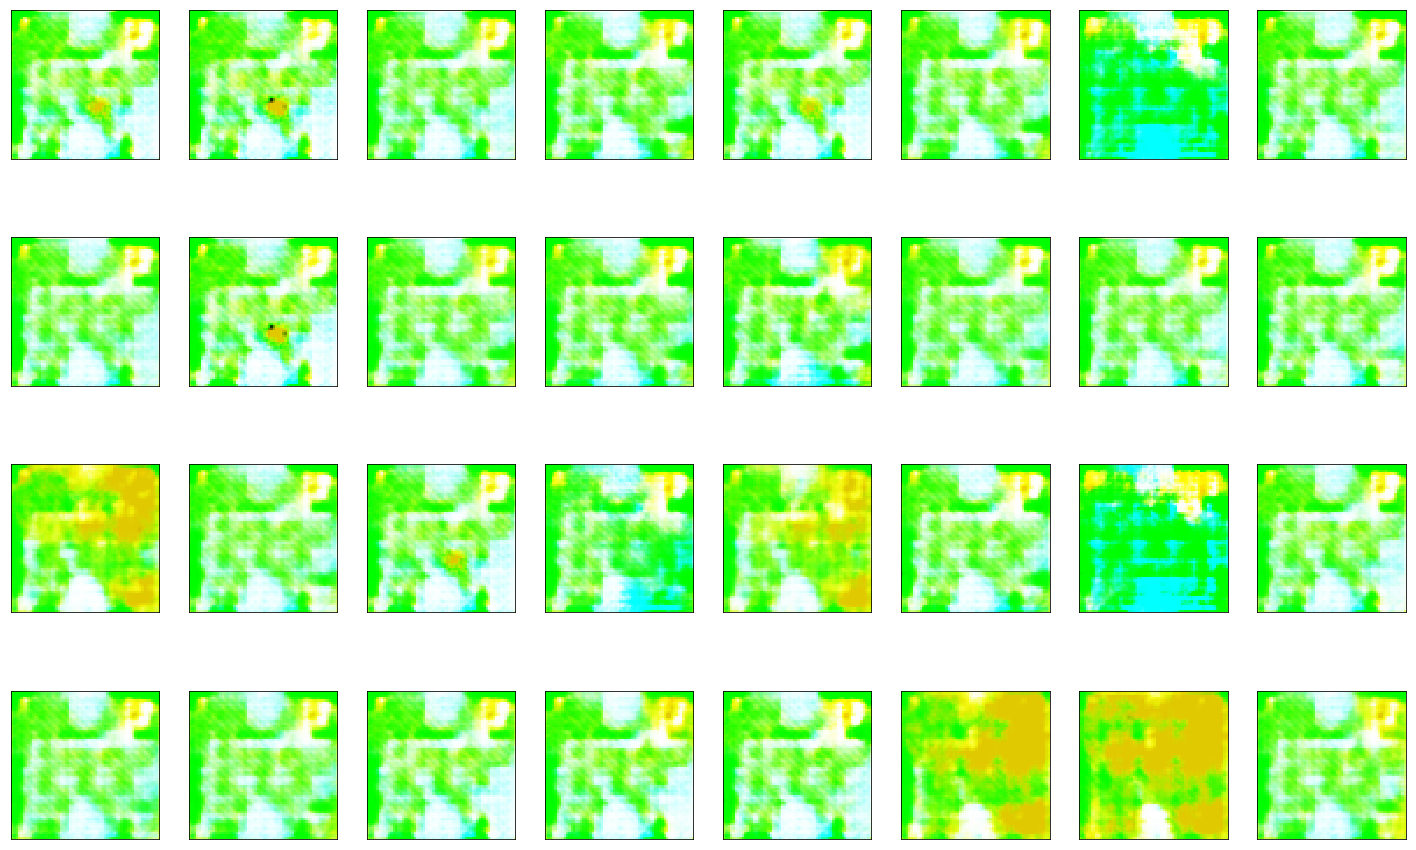

In [11]:
fig = plt.figure(figsize=(25, 16))
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [12]:
shutil.make_archive('images', 'zip', OUT_DIR)

'/kaggle/working/images.zip'

In [13]:
elapsed_time = time.time() - start_time
print(f'All process done in {int(elapsed_time // 3600)} hours {int(elapsed_time % 3600 // 60)} min.')

All process done in 2 hours 38 min.
